In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import boto3

In [ ]:
df = pd.read_csv("bank 1.csv")
df = df.dropna()
df_encoded = pd.get_dummies(df)
X = df_encoded.drop("y_yes", axis=1, errors="ignore")
y = df_encoded.get("y_yes", df_encoded.iloc[:, -1])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [27]:
# Original numeric examples (no string conversion here)
examples = X_test.copy()
examples["predicted"] = model.predict(X_test)
examples["probabilities"] = list(model.predict_proba(X_test))

# Save both string version (for WIT) and numeric version (for prediction)
wit_examples = json.loads(examples.astype(str).to_json(orient="records"))  # For WIT
numeric_examples = examples  # For predictions


WitWidget(config={'model_type': 'classification', 'label_vocab': ['no', 'yes'], 'uses_json_input': True}, layo…

In [28]:
def invoke_claude_3_7_sonnet(prompt):
    try:
        aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
        aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
        aws_region = os.getenv('AWS_REGION', 'us-east-1')

        bedrock_runtime = boto3.client(
            service_name='bedrock-runtime',
            region_name=aws_region,
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key
        )

        request_body = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 130000,
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            "temperature": 0.3
        }

        response = bedrock_runtime.invoke_model(
            modelId="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
            body=json.dumps(request_body)
        )

        response_body = json.loads(response.get("body").read())
        return response_body["content"][0]["text"]

    except Exception as e:
        return f"❌ Error invoking Bedrock model: {e}"


In [10]:
# Show basic statistics and head
print("\nData Preview:")
print(df.head())
print("\nData Description:")
print(df.describe())


Data Preview:
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  

Data Description:
                age       balance           day      duration    

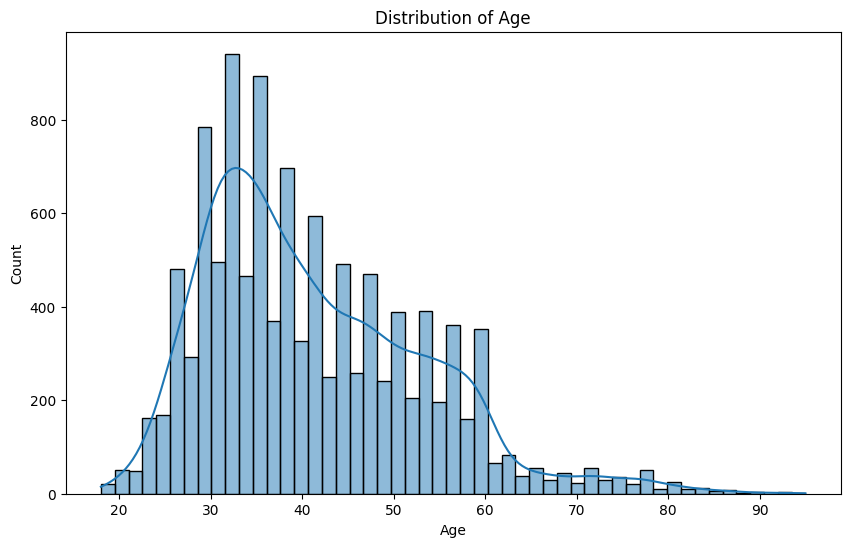

In [14]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

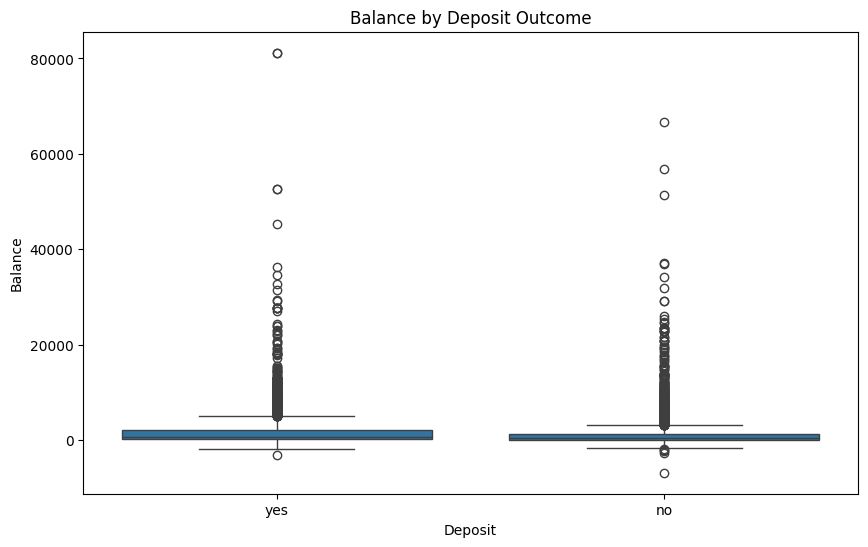

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="deposit", y="balance", data=df)
plt.title("Balance by Deposit Outcome")
plt.xlabel("Deposit")
plt.ylabel("Balance")
plt.show()

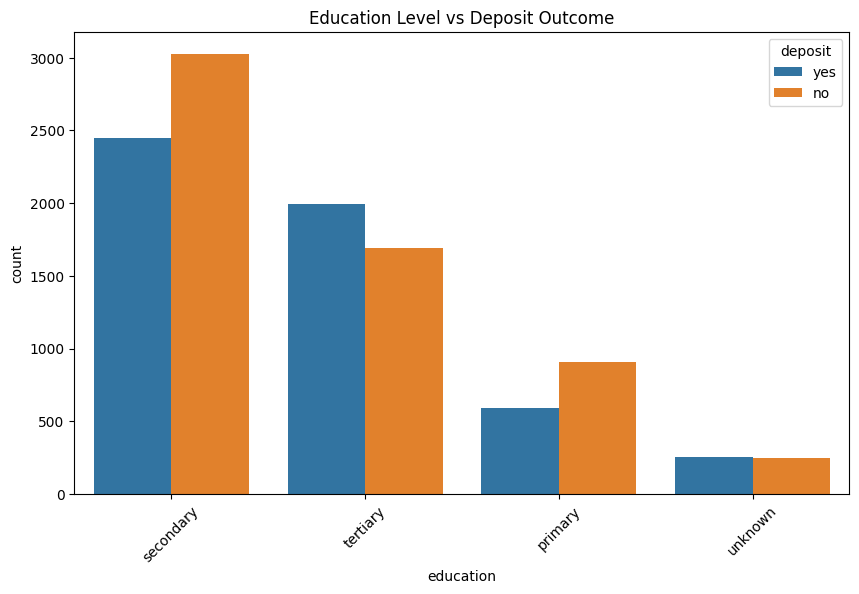

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x="education", hue="deposit", data=df)
plt.title("Education Level vs Deposit Outcome")
plt.xticks(rotation=45)
plt.show()

In [ ]:
def get_bedrock_llm_summary_claude(example):
    prompt = f"""You are a helpful assistant that explains machine learning predictions.

Please summarize the following prediction record in a way that's understandable for non-technical users. Highlight key features contributing to the prediction:

{json.dumps(example, indent=2)}

Return the explanation in plain language."""
    
    return invoke_claude_3_7_sonnet(prompt)


In [19]:
pd.DataFrame(wit_examples).head()


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,deposit_no,deposit_yes,predicted,probabilities
0,33,-482,29,90,3,-1,0,False,False,False,...,False,False,False,False,False,True,True,False,False,[1. 0.]
1,29,316,3,156,1,-1,0,False,False,False,...,False,False,False,False,False,True,False,True,True,[0.02 0.98]
2,40,693,30,427,1,-1,0,False,False,False,...,False,False,False,False,False,True,True,False,False,[0.99 0.01]
3,41,90,15,77,2,347,4,True,False,False,...,False,False,True,False,False,False,True,False,False,[1. 0.]
4,43,36,13,61,1,193,1,False,False,False,...,False,False,True,False,False,False,True,False,False,[0.98 0.02]


In [29]:
def simulate_scenario(original_df, changes: dict, description=""):
    modified = original_df.copy()
    for feature, new_value in changes.items():
        if feature in modified.columns:
            try:
                modified[feature] = float(new_value)  # Ensure float
            except ValueError:
                pass
    return (description, modified)

In [32]:
def predict_and_summarize(scenario_df, description=""):
    numeric_df = scenario_df.copy()
    numeric_df = numeric_df.drop(["predicted", "probabilities"], axis=1, errors="ignore")
    numeric_df = numeric_df.astype(float)

    prediction = model.predict(numeric_df)[0]
    proba = model.predict_proba(numeric_df)[0].tolist()

    result = numeric_df.copy()
    result["predicted"] = prediction
    result["probabilities"] = [proba]  # ✅ Fix: wrap list in another list

    # Send single record to LLM
    return get_bedrock_llm_summary_claude(json.loads(result.to_json(orient="records"))[0])


In [33]:
# Loop through a few numeric examples (used for inference)
for i, row in numeric_examples.head(3).iterrows():
    print(f"\n\n================== 🔎 What-If Analysis for Sample {i+1} ==================\n")
    
    df_sample = pd.DataFrame([row])

    scenarios = [
        simulate_scenario(df_sample, {"age": row["age"] + 10}, "Customer is 10 years older"),
        simulate_scenario(df_sample, {"balance": row["balance"] + 5000}, "Customer has ₹5,000 more in account balance"),
        simulate_scenario(df_sample, {"loan_yes": 1.0, "loan_no": 0.0}, "Customer now has a loan"),
        simulate_scenario(df_sample, {"education_university.degree": 1.0, "education_secondary": 0.0}, "Changed education to University Degree"),
    ]

    for desc, modified_sample in scenarios:
        summary = predict_and_summarize(modified_sample.copy(), desc)
        print(f"📌 {desc}\n{summary}\n")




================== 🔎 What-If Analysis for Sample 7626 ==================

📌 Customer is 10 years older
# Customer Profile Summary

This record shows a 43-year-old married technician with higher education (tertiary) who was contacted in July via cell phone. The model predicted this person would **not** make a deposit.

## Key factors influencing this prediction:

- **Financial situation**: The customer has a negative account balance (-482), which strongly suggests limited funds available for deposits
- **Contact history**: No previous marketing campaigns were successful with this customer (marked as "unknown" outcome)
- **Short interaction**: The call duration was only 90 seconds, suggesting limited interest
- **Housing situation**: The customer has an existing housing loan, which may limit financial flexibility
- **Contact timing**: The contact occurred on the 29th of July, possibly near month-end when finances are tighter

The model is highly confident in this prediction (100% proba